Let's assume that we have a random model that we counterfactually force to gate at certain times. What does the advantage of doing so look like? 

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoTokenizer

from clean_code.flexible_bitter_llm import FlexibleBitterLLM, Gemma2RotaryEmbedding, IndependentWrapperGater
from clean_code.bitter_llm import RandomGater
torch.serialization.add_safe_globals([nn.modules.sparse.Embedding])

# Import matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import HTML
from scipy import stats
from clean_code.flexible_bitter_llm import select_next_token_logits
import numpy as np

from tqdm import trange

In [34]:
def resample_gates(batch, model, forward_minibatch_size, n_forward_minibatches):

    full_logits = []
    full_gate_samples = []

    for i in trange(n_forward_minibatches):
        with torch.no_grad():
            full_out = model(batch.expand(forward_minibatch_size, -1))
        full_logits.append(full_out["logits"])
        full_gate_samples.append(full_out["down_gate_samples"])

    full_logits = torch.cat(full_logits, dim=0)
    full_gate_samples = torch.cat(full_gate_samples, dim=0)

    early_logits = full_out["early_logits"][0, :, :] # the early logits do not depend on the gate samples.
    early_logits = early_logits.unsqueeze(0) # Put the batch dimension back in.

    return full_logits, full_gate_samples, early_logits


In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
byte5_tokenizer = AutoTokenizer.from_pretrained("google/byt5-large")

In [4]:
load_model_with_filter = False
if load_model_with_filter:
    my_model = torch.load("experiment_28/model_8.pt", weights_only=False)
    filter_vals = [v.item() for v in my_model.down_layer_gate.filter]
else:
    my_model = torch.load("training_random_base_model/random_select_early_output_base_model_42.pt", weights_only=False)
    my_model.down_layer_gate = IndependentWrapperGater(my_model.down_layer_gate)

In [5]:
import pickle
with open("./test_openwebtext_samples.pkl", 'rb') as f:
    my_samples = pickle.load(f)
    my_samples = my_samples["text"]

min_samples_length = min([len(s) for s in my_samples])
print(f"Minimum sample length: {min_samples_length}")

my_batch = byte5_tokenizer(my_samples, return_tensors="pt", padding=True)["input_ids"].to(device)
my_batch = my_batch[:32, :1024]
my_batch.shape


Minimum sample length: 751


torch.Size([32, 1024])

In [6]:
my_samples[0]

'CHICAGO -- Size is a nice characteristic to have in hockey, but the Chicago Blackhawks have proven it\'s not everything.\n\nThe Blackhawks have emphasized speed and skill over size, and they\'ve been successful, winning two of the past five Stanley Cup championships (2010 and 2013).\n\nChicago is preparing for its fifth Western Conference Final in the past seven seasons and is considered by some as the favorite to defeat the bigger Anaheim Ducks; Game 1 is Sunday at Honda Center (3 p.m. ET; NBC, CBC, TVA Sports). That probably wouldn\'t have happened a decade ago, when giant men on skates clogged the ice surface, but the NHL and game have changed.\n\nBeing small isn\'t a detriment anymore for guys with great hands and the ability to skate fast.\n\n"I would say if it was like the early 2000s or late \'90s, it seemed like it was a bigger man\'s game and it would be tough for guys [my] size to end up even making the NHL," said 5-foot-11, 177-pound right wing Patrick Kane, who leads the B

In [35]:
full_logits, full_gate_samples, _ = resample_gates(batch_of_interest, my_model, 32, 256)

full_logits.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:53<00:00,  4.83it/s]


torch.Size([8192, 1024, 256])

In [41]:
with torch.no_grad():
    out = my_model(my_batch)
out["logits"].shape

torch.Size([32, 1024, 256])

In [43]:
next_token_ids = my_batch[:, 1:]
next_token_logits = select_next_token_logits(out["logits"], next_token_ids)
early_exit_next_token_logits = select_next_token_logits(out["early_logits"], next_token_ids)

---
Q: what does the actual distribution of next byte logits look like?

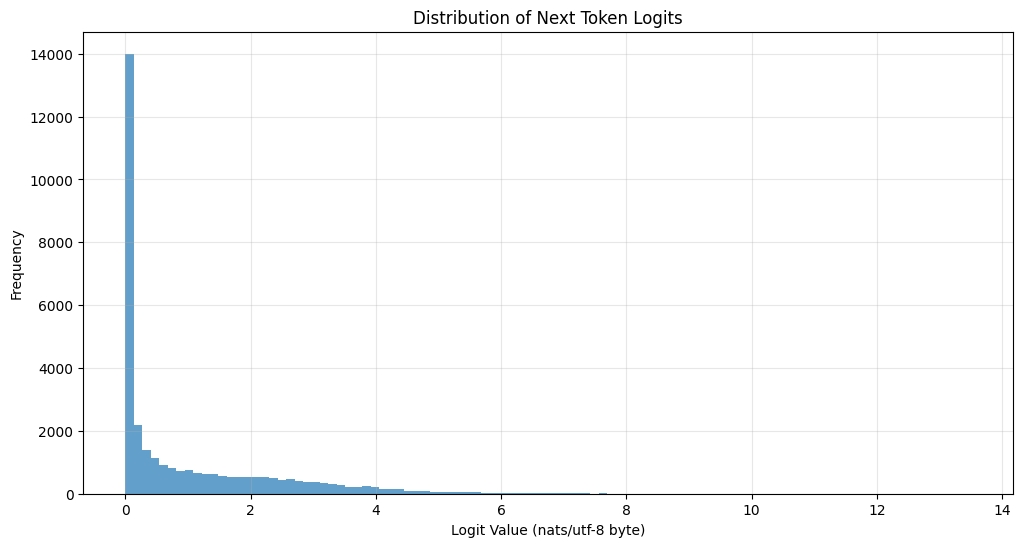

In [44]:
import matplotlib.pyplot as plt

# Flatten the logits and convert to numpy for plotting
all_logits = next_token_logits.cpu().numpy().flatten()

plt.figure(figsize=(12, 6))
plt.hist(all_logits, bins=100, alpha=0.7)
plt.title('Distribution of Next Token Logits')
plt.xlabel('Logit Value (nats/utf-8 byte)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

--- 
Question: how do the next token logits covary with the token index?

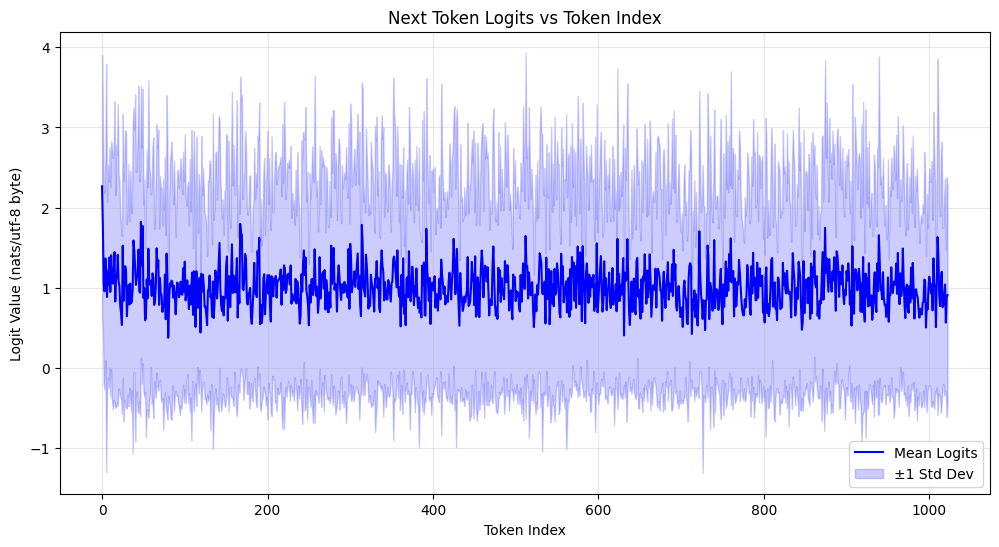

In [45]:
# Calculate mean and std of logits across batch dimension for each token position
mean_logits = next_token_logits.mean(dim=0).cpu().numpy()
std_logits = next_token_logits.std(dim=0).cpu().numpy()
token_indices = np.arange(len(mean_logits))

plt.figure(figsize=(12, 6))
plt.plot(token_indices, mean_logits, label='Mean Logits', color='blue')
plt.fill_between(token_indices, 
                 mean_logits - std_logits,
                 mean_logits + std_logits,
                 alpha=0.2, color='blue', label='±1 Std Dev')

plt.title('Next Token Logits vs Token Index')
plt.xlabel('Token Index')
plt.ylabel('Logit Value (nats/utf-8 byte)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


---
Question: what does the graph of logit diffs (early vs late) look like?

In [46]:
print(f"{next_token_logits.mean()=}")
print(f"{early_exit_next_token_logits.mean()=}")


next_token_logits.mean()=tensor(1.0047, device='cuda:0')
early_exit_next_token_logits.mean()=tensor(1.2269, device='cuda:0')


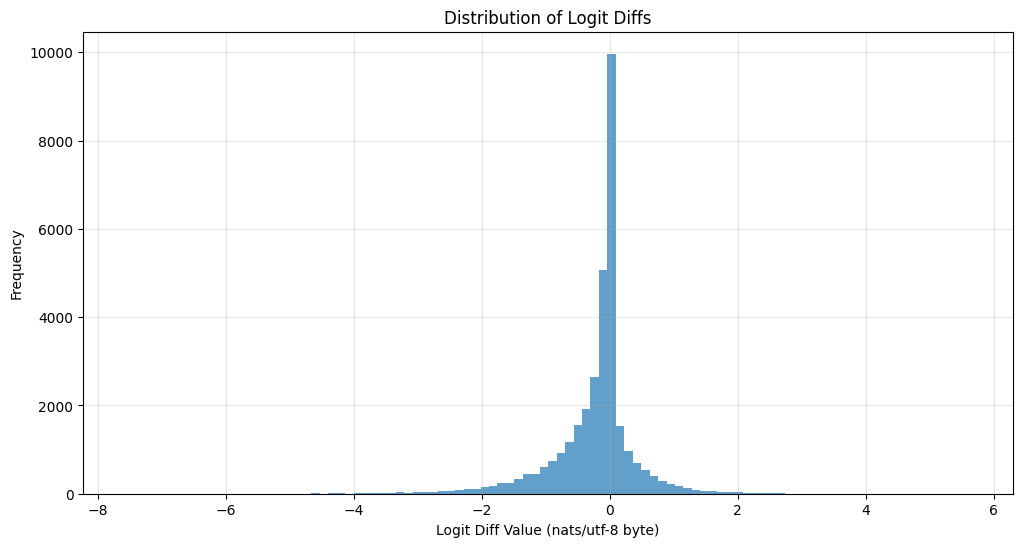

In [47]:
logit_diffs = next_token_logits - early_exit_next_token_logits

all_logit_diffs = logit_diffs.cpu().numpy().flatten()

plt.figure(figsize=(12, 6))
plt.hist(all_logit_diffs, bins=100, alpha=0.7)
plt.title('Distribution of Logit Diffs')
plt.xlabel('Logit Diff Value (nats/utf-8 byte)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [48]:
print(f"Mean logit diff: {all_logit_diffs.mean()}")
print(f"Std logit diff: {all_logit_diffs.std()}")

Mean logit diff: -0.22228717803955078
Std logit diff: 0.6674811840057373


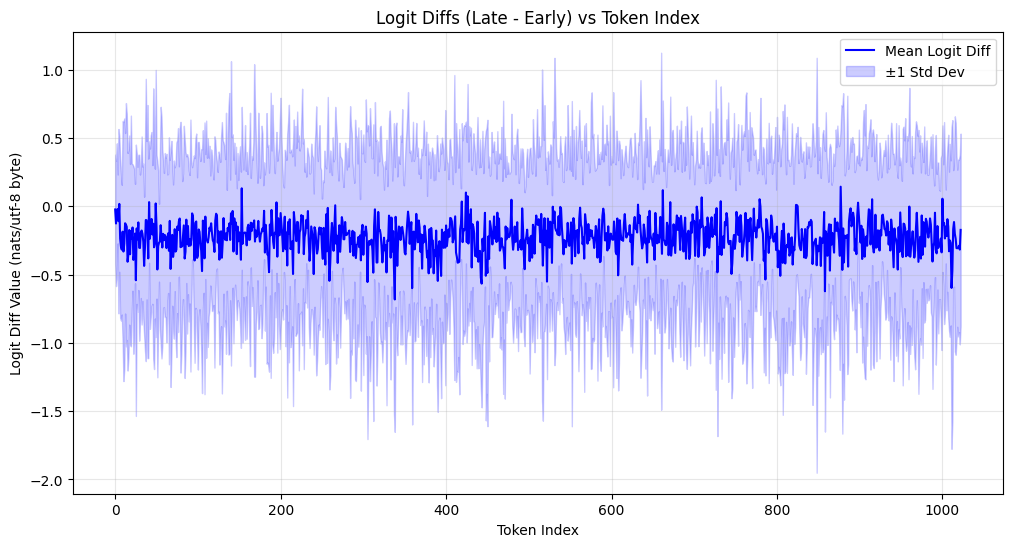

In [49]:
mean_logit_diffs = logit_diffs.mean(dim=0).cpu().numpy()
std_logit_diffs = logit_diffs.std(dim=0).cpu().numpy()

plt.figure(figsize=(12, 6))
plt.plot(token_indices, mean_logit_diffs, label='Mean Logit Diff', color='blue')
plt.fill_between(token_indices,
                 mean_logit_diffs - std_logit_diffs,
                 mean_logit_diffs + std_logit_diffs,
                 alpha=0.2, color='blue', label='±1 Std Dev')

plt.title('Logit Diffs (Late - Early) vs Token Index')
plt.xlabel('Token Index')
plt.ylabel('Logit Diff Value (nats/utf-8 byte)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


---
How well do different estimates of advantage correlate with the true advantage?

In [50]:
sample_of_interest = 0
batch_of_interest = my_batch[sample_of_interest, :].unsqueeze(0)
batch_of_interest.shape

torch.Size([1, 1024])

In [51]:
resample_next_token_logits = select_next_token_logits(full_logits, batch_of_interest[:, 1:].expand(32*256, -1))
resample_next_token_logits.shape

torch.Size([8192, 1023])

In [57]:
# Various baselines
expected_next_token_logits_baseline = resample_next_token_logits.mean(dim=0)
print(f"true advantage stderror={resample_next_token_logits.std(dim=0).cpu().numpy()/np.sqrt(32*256)=}")

batch_baseline_estimate = next_token_logits.mean(dim=0)
early_exit_baseline_estimate = early_exit_next_token_logits[sample_of_interest]

# Compute the "true" advantage using many sampling of gating strategies.
next_token_logits_of_interest = next_token_logits[sample_of_interest]
true_advantage = next_token_logits_of_interest - expected_next_token_logits_baseline

expected_next_token_logits_baseline.shape, expected_next_token_logits_baseline.shape, early_exit_baseline_estimate.shape

true advantage stderror=resample_next_token_logits.std(dim=0).cpu().numpy()/np.sqrt(32*256)=array([2.24203124e-08, 1.09352447e-04, 3.90549450e-04, ...,
       7.00448024e-04, 6.14535085e-06, 8.12912743e-06], shape=(1023,))


(torch.Size([1023]), torch.Size([1023]), torch.Size([1023]))

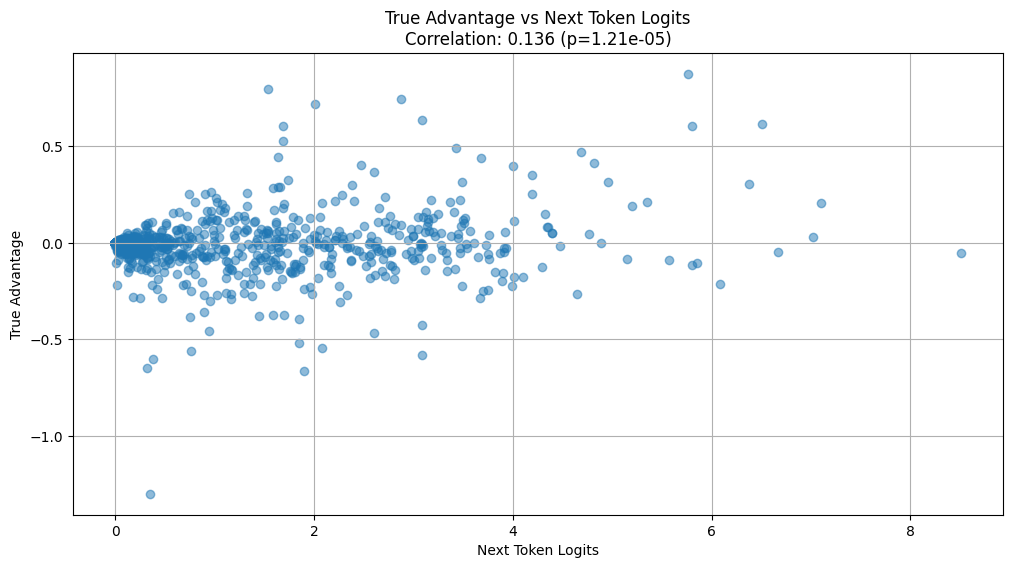

In [53]:
# Plot 1: raw REINFORCE estimate with correlation
plt.figure(figsize=(12, 6))
plt.scatter(next_token_logits_of_interest.cpu().numpy(), true_advantage.cpu().numpy(), alpha=0.5)
plt.xlabel('Next Token Logits')
plt.ylabel('True Advantage')

# Compute correlation and p-value
correlation, p_value = stats.pearsonr(next_token_logits_of_interest.cpu().numpy(), true_advantage.cpu().numpy())
plt.title(f'True Advantage vs Next Token Logits\nCorrelation: {correlation:.3f} (p={p_value:.2e})')
plt.grid(True)
plt.show()

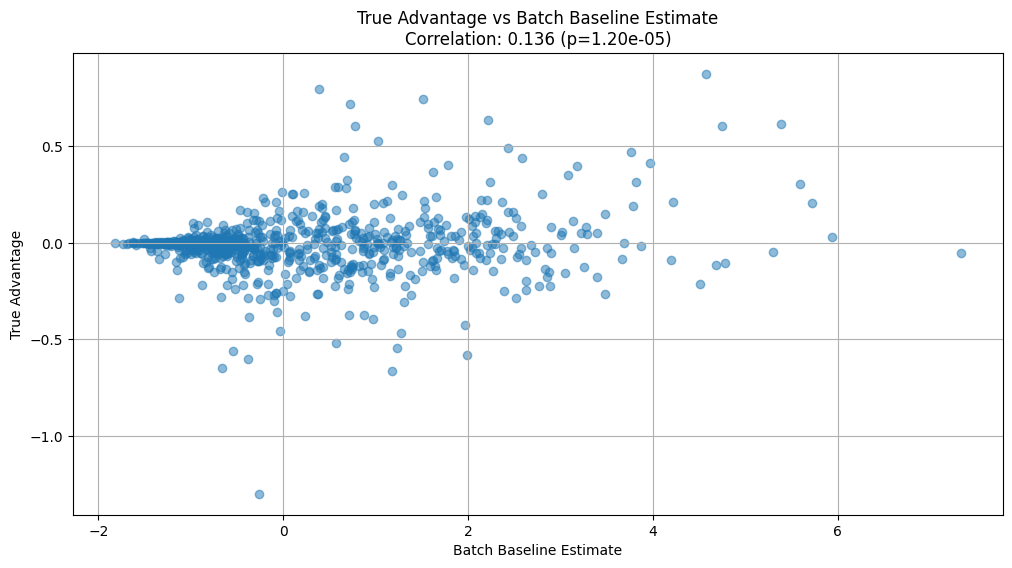

In [54]:
batch_relative_advantage = next_token_logits_of_interest - batch_baseline_estimate
plt.figure(figsize=(12, 6))
plt.scatter(batch_relative_advantage.cpu().numpy(), true_advantage.cpu().numpy(), alpha=0.5)
correlation, p_value = stats.pearsonr(batch_relative_advantage.cpu().numpy(), true_advantage.cpu().numpy())
plt.xlabel('Batch Baseline Estimate')
plt.ylabel('True Advantage')
plt.title(f'True Advantage vs Batch Baseline Estimate\nCorrelation: {correlation:.3f} (p={p_value:.2e})')
plt.grid(True)

Text(0.5, 1.0, 'True Advantage vs Early Exit Baseline Estimate\nCorrelation: 0.368 (p=3.95e-34)')

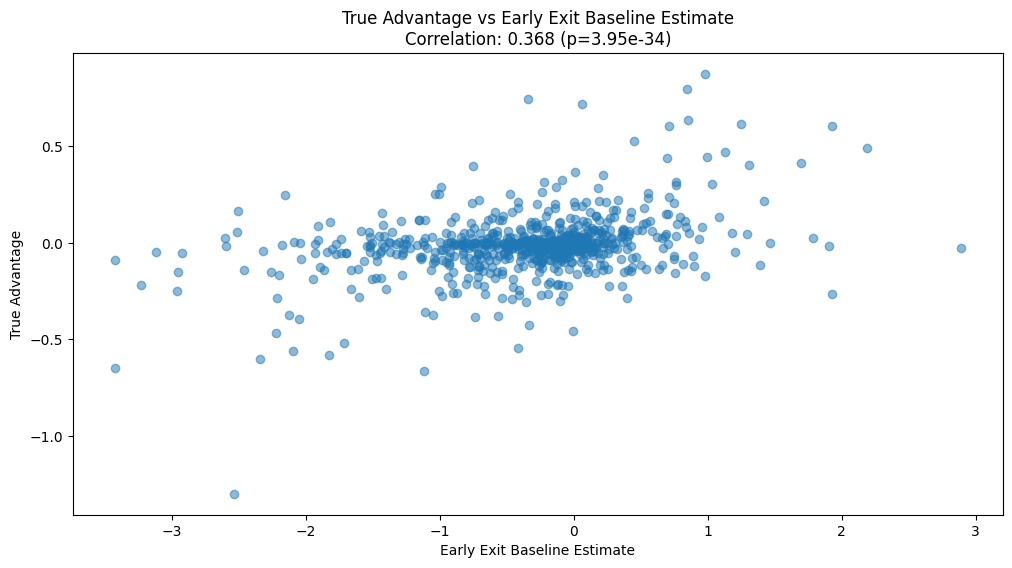

In [55]:
early_exit_relative_advantage = next_token_logits_of_interest - early_exit_baseline_estimate
plt.figure(figsize=(12, 6))
plt.scatter(early_exit_relative_advantage.cpu().numpy(), true_advantage.cpu().numpy(), alpha=0.5)
correlation, p_value = stats.pearsonr(early_exit_relative_advantage.cpu().numpy(), true_advantage.cpu().numpy())
plt.xlabel('Early Exit Baseline Estimate')
plt.ylabel('True Advantage')
plt.title(f'True Advantage vs Early Exit Baseline Estimate\nCorrelation: {correlation:.3f} (p={p_value:.2e})')

In [63]:
early_exit_relative_advantage.mean()

tensor(-0.2627, device='cuda:0')

Text(0.5, 1.0, 'True Advantage vs Double Baseline Estimate\nCorrelation: 0.363 (p=2.64e-33)')

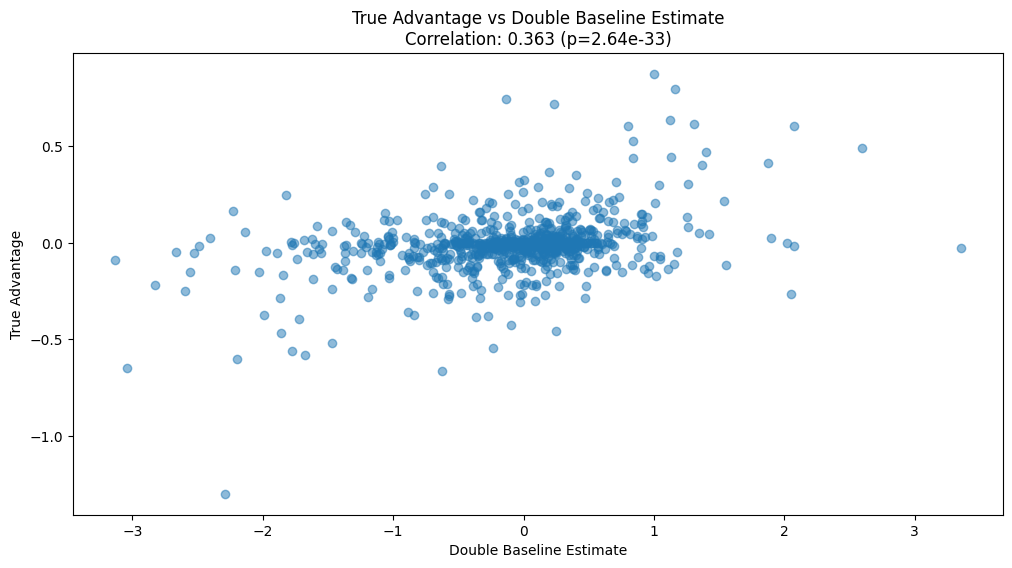

In [59]:
batch_early_exit_diff = next_token_logits - early_exit_next_token_logits
double_baseline_estimate = early_exit_relative_advantage - batch_early_exit_diff.mean(dim=0)
plt.figure(figsize=(12, 6))
plt.scatter(double_baseline_estimate.cpu().numpy(), true_advantage.cpu().numpy(), alpha=0.5)
correlation, p_value = stats.pearsonr(double_baseline_estimate.cpu().numpy(), true_advantage.cpu().numpy())
plt.xlabel('Double Baseline Estimate')
plt.ylabel('True Advantage')
plt.title(f'True Advantage vs Double Baseline Estimate\nCorrelation: {correlation:.3f} (p={p_value:.2e})')

In [61]:
double_baseline_estimate.mean()

tensor(-0.0404, device='cuda:0')